In [1]:
import intake
import h5py
from dataclasses import dataclass
import matplotlib
import matplotlib.pyplot as plt

# Latex points to inches conversion factor
PTS_PER_INCH = 72.26999
# Latex text width in points
TEXT_WIDTH_PTS = 505.12177
# Latex column width in points
COLUMN_WIDTH_PTS = TEXT_WIDTH_PTS / 2
# Latex column width in inches
COLUMN_WIDTH_INCHES = COLUMN_WIDTH_PTS / PTS_PER_INCH
# Latex text width in inches
TEXT_WIDTH_INCHES = TEXT_WIDTH_PTS / PTS_PER_INCH
# DPI for figures
DPI = 600
# Font scale for figures
FONT_SCALE = 0.5

plt.rcParams['font.stretch'] = 'condensed'
plt.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('xtick', labelsize=5) 
matplotlib.rc('ytick', labelsize=5) 


In [2]:
url = "s3://mast/level1/shots/30420.zarr"
catalog  = intake.open_catalog('https://mastapp.site/intake/catalog.yml')
dataset = catalog.level1.sources(url=f"{url}/amc")
dataset = dataset.to_dask()
plasma_current = dataset['plasma_current']

dataset = catalog.level1.sources(url=f"{url}/aim")
dataset = dataset.to_dask()
dalpha = dataset['da_to10']

dataset = catalog.level1.sources(url=f"{url}/xsx")
dataset = dataset.to_dask()
tcam = dataset['tcam']
hcam_l = dataset['hcam_l']

dataset = catalog.level1.sources(url=f"{url}/xmo")
dataset = dataset.to_dask()
xmo = dataset['omaha_6lz']

tmax = min(0.35, dalpha.time.max())
tmin = max(0, dalpha.time.min())

dalpha = dalpha.sel(time= dalpha.time >= tmin)
dalpha = dalpha.sel(time= dalpha.time <= tmax)

plasma_current = plasma_current.sel(time = plasma_current.time >= tmin)
plasma_current = plasma_current.sel(time = plasma_current.time <= tmax)

tcam = tcam.sel(time=tcam.time >= tmin)
tcam = tcam.sel(time=tcam.time <= tmax)
# tcam = tcam.sum(axis=0)

hcam_l = hcam_l.sel(time=hcam_l.time >= tmin)
hcam_l = hcam_l.sel(time=hcam_l.time <= tmax)
# hcam_l = hcam_l.sum(axis=0)

xmo = xmo.sel(time=xmo.time >= tmin)
xmo = xmo.sel(time=xmo.time <= tmax)

/Users/rt2549/miniconda3/envs/defuse-data/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/Users/rt2549/miniconda3/envs/defuse-data/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


### DEFUSE Events

In [3]:
@dataclass
class TimeWindow:
    time_min: float
    time_max: float

with h5py.File('./out/MASTno30420.h5', mode='r') as f:
    flat_top = f['objDIS']['Discharge']['Flat_top'][:]
    flat_top = TimeWindow(*flat_top.squeeze())

    ramp_up = f['objDIS']['Discharge']['Ramp_up'][:]
    ramp_up = TimeWindow(*ramp_up.squeeze())

    sxr_tmax = f['objDIS']['tq_SXR']['tmax'][:]
    sxr_tmin = f['objDIS']['tq_SXR']['tmin'][:]
    sxr_spike = f['objDIS']['tq_SXR']['spike'][:]
    print(sxr_tmax)

flat_top.time_max = min(flat_top.time_max, tmax)
ramp_up.time_max = min(ramp_up.time_max, tmax)

[[0.1976008 0.2094008 0.2177008 0.2251008 0.2290008 0.2417008 0.2492008
  0.2574008 0.2644008 0.2707008 0.2775008 0.2844008 0.2893008 0.2941008
  0.2986008 0.3046008]]


<xarray.DataArray 'tcam_channel' ()> Size: 84B
array('tcam_11', dtype='<U21')
Coordinates:
    tcam_channel  <U21 84B 'tcam_11'
Attributes:
    units:    


<xarray.DataArray 'tcam' (tcam_channel: 36, time: 175000)> Size: 25MB
dask.array<getitem, shape=(36, 175000), dtype=float32, chunksize=(5, 37500), chunktype=numpy.ndarray>
Coordinates:
  * tcam_channel  (tcam_channel) <U21 3kB '0' '1' '2' ... 'tcam_8' 'tcam_9'
  * time          (time) float64 1MB 8e-07 2.8e-06 4.8e-06 ... 0.35 0.35 0.35
Attributes: (12/17)
    channel_descriptions:  ['Soft X-ray camera: tangential camera. Extreme In...
    description:           Soft X-ray camera: tangential camera. Extreme Inne...
    dims:                  ['tcam_channel', 'time']
    file_name:             None
    format:                None
    label:                 Volt
    ...                    ...
    signal_type:           Raw
    source:                xsx
    time_index:            0
    units:                 V
    uuid:                  10170616-9105-5a61-8077-4770560c0295
    version:               -1

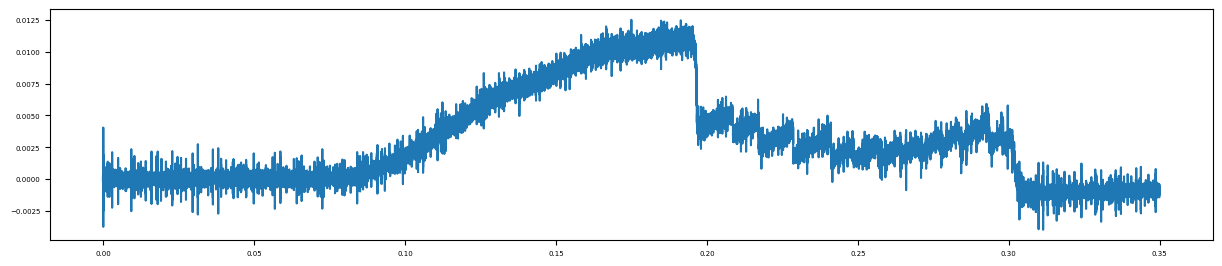

In [6]:
import numpy as np
from matplotlib.colors import LogNorm
from scipy.signal import stft

def plot_mirnov_coil_spectogram(ds, ax):
    ds = ds[-3] - ds[-1]
    # Parameters to limit the number of frequencies
    nperseg = 128 # Number of points per segment
    nfft = 128 # Number of FFT points

    # Compute the Short-Time Fourier Transform (STFT)
    sample_rate = 1/(ds.time[1] - ds.time[0]) 
    f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    norm = LogNorm(vmin=1e-5)
    # norm = None
    cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap='jet', norm=norm)
    # ax.set_ylim(0, 1000)

plt.figure(figsize=(15, 3))
plt.plot(hcam_l.time, tcam[-16])
print(tcam.tcam_channel[-16])
# fig, ax = plt.subplots(1,1)
# plot_mirnov_coil_spectogram(hcam_l.sel(time=hcam_l.time < .3), ax)
tcam

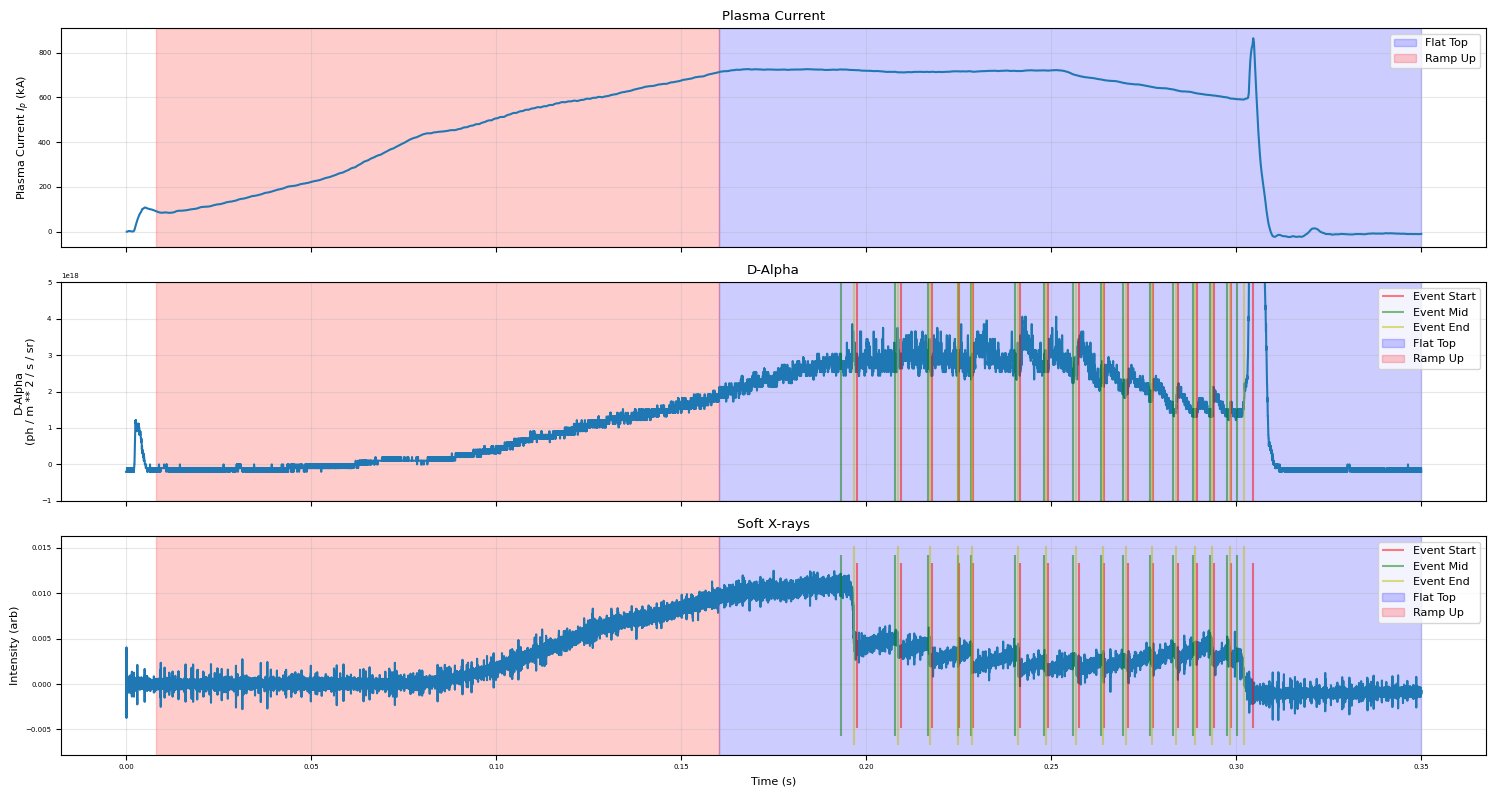

In [9]:
from matplotlib.colors import LogNorm
from matplotlib import rc

PTS_PER_INCH = 72.26999
# Latex text width in points
TEXT_WIDTH_PTS = 505.12177
# Latex column width in points
COLUMN_WIDTH_PTS = TEXT_WIDTH_PTS / 2
# Latex column width in inches
COLUMN_WIDTH_INCHES = COLUMN_WIDTH_PTS / PTS_PER_INCH
# Latex text width in inches
TEXT_WIDTH_INCHES = TEXT_WIDTH_PTS / PTS_PER_INCH
# DPI for figures
DPI = 600

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.stretch'] = 'extra-condensed'
palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

color = '#de2d26'
edgecolor = 'black'
width = .5
bar_params = dict(color=palette[1], edgecolor=edgecolor, width=width)
grid_params = dict(color='black', alpha=0.1, which='both')

def plot_soft_xray_points(sxr_tmax, ax, color='r', label='Soft X-ray Events'):
    y_min, y_max = ax.get_ylim()
    for point in sxr_tmax:
        ax.vlines(point, y_min, y_max, color=color, alpha=0.5, label=label)

fig, axes = plt.subplots(3,1, figsize=(15, 8), sharex=True)
ax1, ax2, ax3 = axes

ax1.plot(plasma_current['time'], plasma_current)
ax1.set_title('Plasma Current')
ax1.set_ylabel(f'Plasma Current $I_p$ ({plasma_current.attrs["units"]})')

ax2.plot(dalpha['time'], dalpha)
ax2.set_ylim(-1e18, 5e18)
ax2.set_title('D-Alpha')
ax2.set_ylabel(f'D-Alpha\n({dalpha.attrs["units"]})')
plot_soft_xray_points(sxr_tmax, ax2, label='Event Start')
plot_soft_xray_points(sxr_tmin, ax2, label='Event Mid', color='g')
plot_soft_xray_points(sxr_spike, ax2, label='Event End', color='y')

ax3.plot(tcam.time, tcam[-16])
ax3.set_title('Soft X-rays')
ax3.set_ylabel('Intensity (arb)')
ax3.set_xlabel('Time (s)')
plot_soft_xray_points(sxr_tmax, ax3, label='Event Start')
plot_soft_xray_points(sxr_tmin, ax3, label='Event Mid', color='g')
plot_soft_xray_points(sxr_spike, ax3, label='Event End', color='y')

for ax in axes:
    ax.grid('both', alpha=0.3)
    ax.axvspan(flat_top.time_min, flat_top.time_max, alpha=0.2, color='b', label='Flat Top')
    ax.axvspan(ramp_up.time_min, ramp_up.time_max, alpha=0.2, color='r', label='Ramp Up')
    ax.legend(loc='upper right', fontsize=8)


plt.tight_layout()
plt.savefig('channels.png', dpi=DPI)